In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

#Viewers
from hsiViewer import hsi_viewer as hv
from hsiViewer import hsi_layers_viewer as hvl

In [ ]:
# Download spectral library:
#hsi_data.download('UPWINS_4_16_2024')
#fname = hsi_data.get_fname('UPWINS_4_16_2024')

# Download image:
#hsi_data.download('VegBaccharisUPWINS')
#fname = hsi_data.get_fname('VegBaccharisUPWINS')

Downloading...
From: https://drive.google.com/uc?id=11Zn-DxlVevtg-KAKnDRiPEVxnLYXDl5h
To: /Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_libraries/UPWINS_4_16_2024.zip
100%|██████████| 6.88M/6.88M [00:00<00:00, 40.3MB/s]


File saved as: C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr
File saved as: C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli
 
Available Files:
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr
Primary Image Filename:
C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli


Downloading...
From (original): https://drive.google.com/uc?id=1e5SloCAzXGIfDRlzhqYcmQ5JUMC8DweC
From (redirected): https://drive.google.com/uc?id=1e5SloCAzXGIfDRlzhqYcmQ5JUMC8DweC&confirm=t&uuid=89f0b86b-5526-4999-a0b6-54e1fc68c8d7
To: /Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS.zip
100%|██████████| 86.2M/86.2M [00:03<00:00, 28.2MB/s]


File saved as: C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref
File saved as: C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr
 
Available Files:
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref
/Users/elarocco/Desktop/uva_phd_2024/remote_sensing/development/C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr
Primary Image Filename:
C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref


## Download the hyperspectral image

In this case, we will be using a hyperspectral image from the RIT test over Cooke City, Montana. (https://dirsapps.cis.rit.edu/blindtest/)

In [3]:
# load hyperspectral image
fname = './C/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
fname_hdr = './C/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (300, 600, 343)
Shape of imList = (180000, 343)


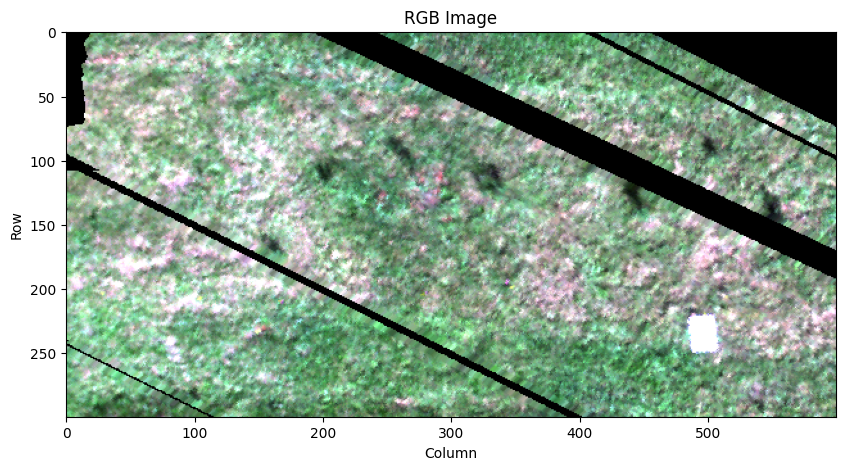

In [4]:
# display the image
sm2.display_RGB(imArr, wl_im, rotate=False)
plt.title('RGB Image');

# Download the Spectral Library for Target Detection

In [5]:
# load spectral library
fname = './C/spectral_data/spectral_images/UPWINS_4_16_2024/UPWINS_4_16_2024.sli'
fname_hdr = './C/spectral_data/spectral_images/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname_hdr, fname)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)


### Resampling the library wavelength to match the image.

In [6]:
resampler = spectral.BandResampler(wl_lib, wl_im)
spec = resampler(lib.spectra.T).T

print(f'The shape of the spectral library is {spec.shape}.')
print(f'({spec.shape[0]} spectra with {spec.shape[1]} bands.)')

wl = wl_im # the wavelengths for the image and the resampled library

The shape of the spectral library is (938, 343).
(938 spectra with 343 bands.)


## 1. Compute the mean and covariance.

In [7]:
C = np.cov(imList.T) 
m = np.mean(imList, axis=0)

## 2. Whiten the Image

In [8]:
# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse, if needed
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)
ImListDemean = imList - m
WimList = np.matmul(W.T, ImListDemean.T).T

## 3. Whiten the spectral library

In [9]:
SpecDemean = spec - m
Wspec = np.matmul(W.T, SpecDemean.T).T

## 4. Compute the values for MF efficiently.

In [10]:
print(f'Whitened pixel array shape: {WimList.shape}.')
print(f'Whitened target library array shape: {Wspec.shape}.')
ntargets = Wspec.shape[0]

Whitened pixel array shape: (180000, 343).
Whitened target library array shape: (938, 343).


# MF

In [11]:
# The computation is now simple
numerator = np.matmul(WimList,Wspec.T)
denom = np.sum(Wspec**2, axis=1)
MF = np.squeeze(numerator / denom)

# Lets reshape this result so we can compare it to the image
MF = np.reshape(MF, (im.nrows, im.ncols, ntargets))

# ACE

In [14]:
numerator = np.matmul(WimList,Wspec.T)

XX = np.reshape(np.sqrt(np.sum(WimList**2,axis=1)), (180000,1))
TT = np.reshape(np.sqrt(np.sum(Wspec**2,axis=1)),(938,1))
denominator = np.matmul(XX,TT.T)

ACE = np.squeeze(numerator / denominator)

# Lets reshape this result so we can compare it to the image
ACE = np.reshape(ACE, (im.nrows, im.ncols, ntargets))


# ROIs

In [15]:
import pickle
fname = './C/spectral_data/spectral_images/UPWINS_4_16_2024/UPWINS Baccharis Halimifolia.pkl'
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

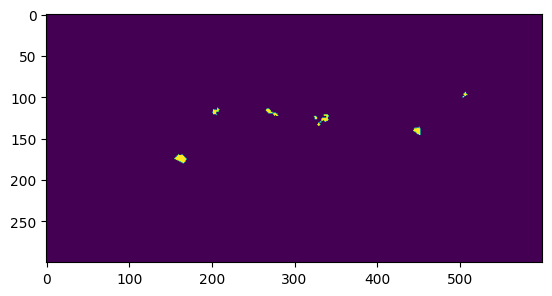

In [16]:
plt.imshow(roiData.masks['Baccharis Halimifolia'])

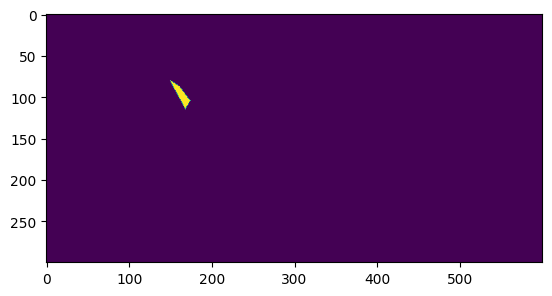

In [36]:
plt.imshow(roiData.masks['Background Scenesced'])

In [17]:
roiData.names

['Baccharis Halimifolia',
 'Flag',
 'Ribbon',
 'Background Healthy',
 'Background Scenesced']

In [28]:
roiData.masks

{'Baccharis Halimifolia': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Flag': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'Ribbon': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
  

In [19]:
roiData.df

,Name,Color,Pixel_x,Pixel_y,399.096008,400.854004,402.612,404.369995,406.127991,407.885986,...,984.531006,986.289001,988.047974,989.80603,991.564026,993.322021,995.080017,996.838013,998.596008,1000.349976
0,Baccharis Halimifolia,#fa3232,175,155,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
1,Baccharis Halimifolia,#fa3232,174,156,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
2,Baccharis Halimifolia,#fa3232,175,156,0.0334,0.0369,0.0309,0.0318,0.0287,0.0324,...,0.4090,0.3906,0.4206,0.3356,0.3441,0.3810,0.3301,0.3485,0.3527,0.3558
3,Baccharis Halimifolia,#fa3232,173,157,0.0282,0.0368,0.0366,0.0344,0.0230,0.0356,...,0.4109,0.3889,0.4285,0.3314,0.3840,0.3716,0.3766,0.3416,0.3801,0.3947
4,Baccharis Halimifolia,#fa3232,174,157,0.0332,0.0369,0.0311,0.0319,0.0285,0.0325,...,0.4091,0.3905,0.4209,0.3354,0.3456,0.3806,0.3319,0.3482,0.3538,0.3573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Background Scenesced,#baae80,108,172,0.0547,0.0529,0.0493,0.0510,0.0494,0.0515,...,0.3388,0.3305,0.3511,0.3505,0.3243,0.3076,0.3674,0.3502,0.3996,0.3676
250,Background Scenesced,#baae80,104,173,0.0451,0.0459,0.0377,0.0331,0.0342,0.0394,...,0.3737,0.2927,0.3801,0.3776,0.3098,0.4160,0.2905,0.3880,0.3429,0.4168
251,Background Scenesced,#baae80,105,173,0.0460,0.0515,0.0426,0.0450,0.0347,0.0380,...,0.3536,0.3609,0.3262,0.2731,0.3314,0.3233,0.3458,0.3880,0.3494,0.4168
252,Background Scenesced,#baae80,106,173,0.0425,0.0466,0.0452,0.0468,0.0481,0.0403,...,0.2934,0.3556,0.2697,0.3226,0.3806,0.3279,0.3358,0.3361,0.3974,0.2698


In [27]:
roiData.masks['Baccharis Halimifolia'].shape

(300, 600)

In [33]:
roiData.masks['Baccharis Halimifolia'].flatten().shape

(180000,)

In [ ]:
# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((300,600))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (300*600))

1410

In [ ]:
#343 bands (columns)
#1410 rows? not 180000? - only certain pixels were labeled

Index([     'Name',     'Color',   'Pixel_x',   'Pixel_y',  399.096008,
        400.854004,     402.612,  404.369995,  406.127991,  407.885986,
       ...
        984.531006,  986.289001,  988.047974,   989.80603,  991.564026,
        993.322021,  995.080017,  996.838013,  998.596008, 1000.349976],
      dtype='object', length=347)

In [ ]:
gt_list = 

In [12]:
# load the associated ground truth image
fname_gt = './C/spectral_data/spectral_images/Cooke_City_self_test_ROIs.txt'
file1 = open(fname_gt, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: F1 Site 12 - Full
Index: 0
Number of points: 1
 
Name: F1 Site 12 - Sub
Index: 1
Number of points: 8
 
Name: F1 Site 12 - Guard
Index: 2
Number of points: 16
 
Name: F2 Site 5 - Full
Index: 3
Number of points: 1
 
Name: F2 Site 5 - Sub
Index: 4
Number of points: 8
 
Name: F2 Site 5 - Guard
Index: 5
Number of points: 16
 
Name: F3a Site 4 - Full
Index: 6
Number of points: 1
 
Name: F3a Site 4 - Sub
Index: 7
Number of points: 8
 
Name: F3a Site 4 - Guard
Index: 8
Number of points: 16
 
Name: F3b Site 3 - Sub
Index: 9
Number of points: 1
 
Name: F3b Site 3 - Guard
Index: 10
Number of points: 8
 
Name: F4a Site 11 - Full
Index: 11
Number of points: 1
 
Name: F4a Site 11 - Sub
Index: 12
Number of points: 8
 
Name: F4a Site 11 - Guard
Index: 13
Number of points: 16
 
Name: F4b Site 10 - Sub
Index: 14
Number of points: 1
 
Name: F4b Site 10 - Guard
Index: 15
Number of points: 8
 
Name: V1 Vehicle 3 - Sub
Index: 16
Number of points: 1
 
Name: V1 Vehicle 3 - Guard
Index: 17
Number of poin

Text(0.5, 1.0, 'Ground Truth Image')

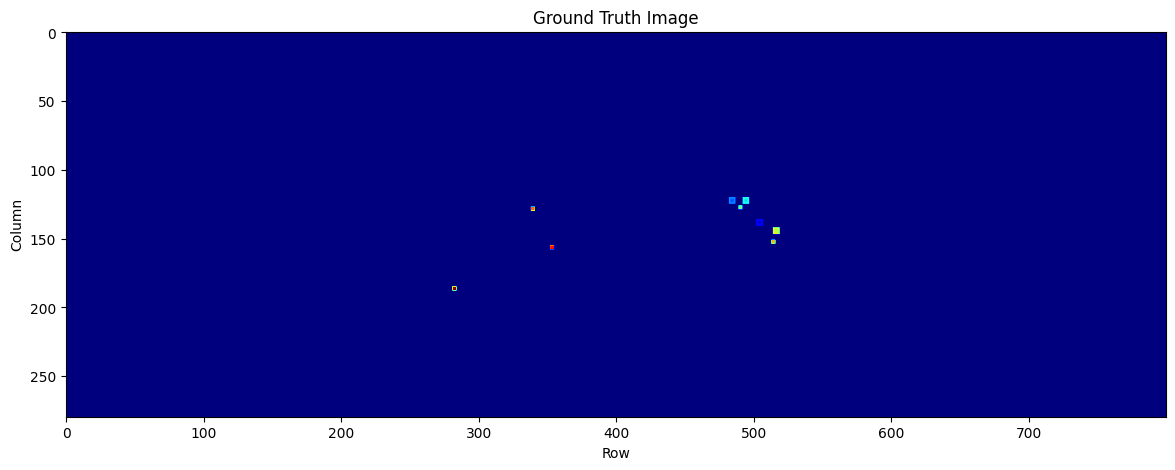

In [13]:
plt.figure(figsize=(15,5)) 
plt.imshow(gt_im, cmap='jet')
plt.xlabel('Row')
plt.ylabel('Column')
plt.title('Ground Truth Image')

# Connect Names

In [60]:
formulas = ['MF', 'ACE']

import pandas as pd

roi_guard_name = ['F1 Site 12 - Guard',
 'F2 Site 5 - Guard',
 'F3a Site 4 - Guard',
 'F3b Site 3 - Guard',
 'F4a Site 11 - Guard',
 'F4b Site 10 - Guard',
 'V1 Vehicle 3 - Guard',
 'V2 Vehicle 4 - Guard',
 'V3 Vehicle 5 - Guard']

roi_sub_name = ['F1 Site 12 - Sub',
 'F2 Site 5 - Sub',
 'F3a Site 4 - Sub',
 'F3b Site 3 - Sub',
 'F4a Site 11 - Sub',
 'F4b Site 10 - Sub',
 'V1 Vehicle 3 - Sub',
 'V2 Vehicle 4 - Sub',
 'V3 Vehicle 5 - Sub']
roi_idx = [1,4,7,9,12,14,16,18,20]

roi_full_name = ['F1 Site 12 - Full',
 'F2 Site 5 - Full',
 'F3a Site 4 - Full',
 'place_holder',
 'F4a Site 11 - Full',
 'place_holder',
 'place_holder',
 'place_holder',
 'place_holder']
roi_full_idx = [0,3,6,0,11] #0 as placeholder

detector_class_name = ['F1_Cloth_Red',
 'F2_Nylon_Yellow',
 'F3a_Cloth_Blue',
 'F3b_Cloth_Blue',
 'F4a_Nylon_Maroon',
 'F4b_Nylon_Maroon',
 'V1_field_spectrum',
 'V2a_field_spectrum',
 'V3_field_spectrum']
detector_class_idx = [17, 15, 13, 13, 11, 11, 3, 1, 0]

# Scatterplots

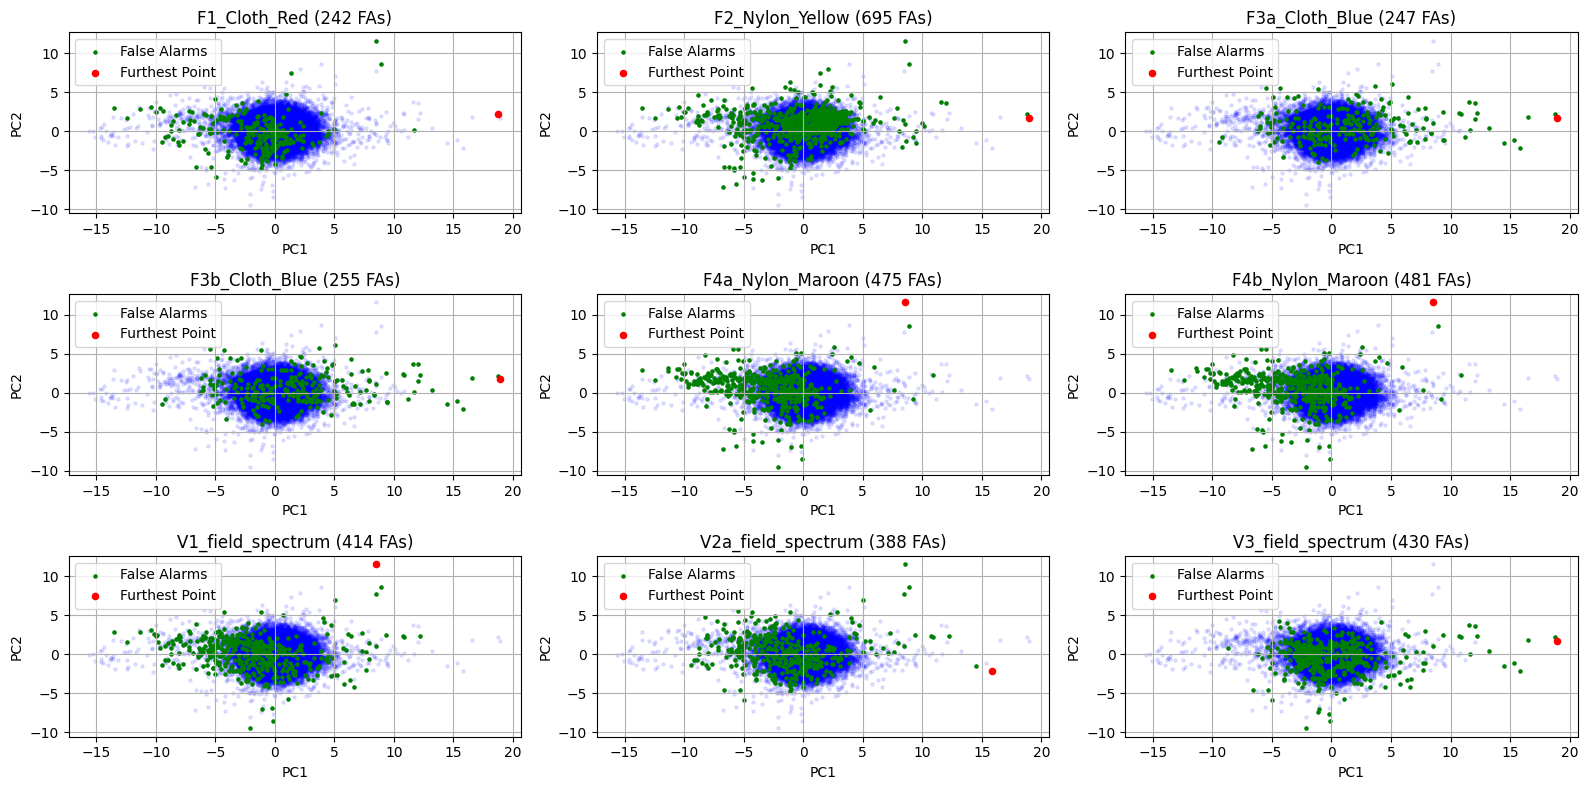

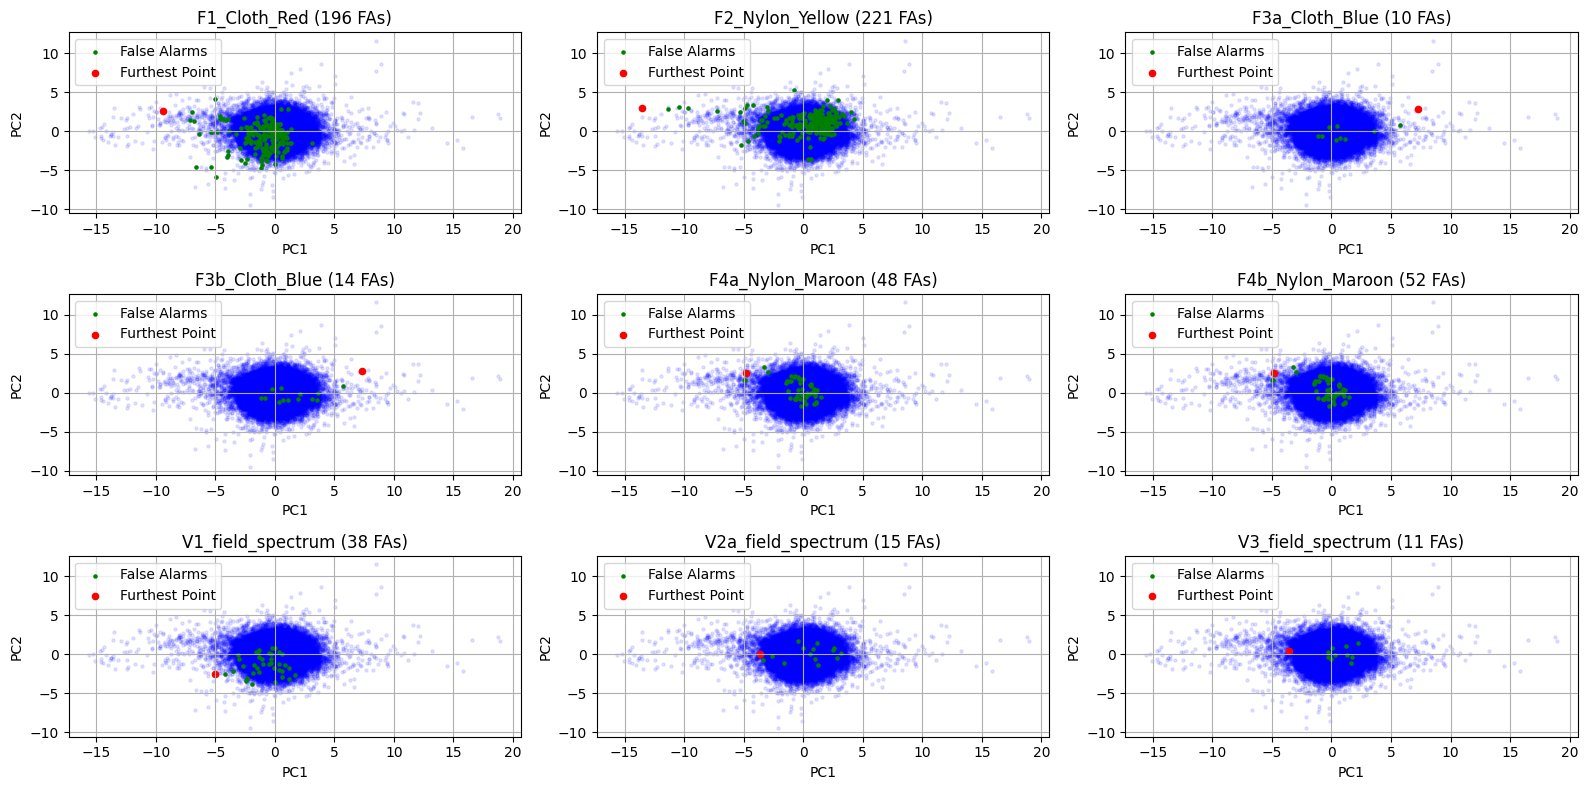

In [23]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = 9

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to easily index

    plot_idx = 0


    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold < 0] = 0
        detections = np.where(MF_threshold > m + 6 * s)
        detections = [list(i) for i in zip(detections[0], detections[1])]

        # ROIS
        rois = groundtruth_classes[roi_sub_name[i]]['locations']
        if i in [0,1,2,4]:
            rois_full = groundtruth_classes[roi_full_name[i]]['locations']
            rois = rois + rois_full
            rois = [[int(num) for num in sublist] for sublist in rois]
        else:
            rois = [[int(num) for num in sublist] for sublist in rois]

        # Guards
        guards = groundtruth_classes[roi_guard_name[i]]['locations']
        guards = [[int(num) for num in sublist] for sublist in guards]

        false_alarms = [item for item in detections if item not in rois and item not in guards]
        true_positives = [item for item in detections if item in rois]


        # Scatter plot
        PC1 = 30
        PC2 = 61

        # Reshape the whitened image spectra to image shape
        WimArr = np.reshape(WimList, (im.nrows, im.ncols, im.nbands))
        x_list = []
        y_list = []
        F1_idx = false_alarms
        for k in range(len(F1_idx)):
            lst = WimArr[F1_idx[k][0], F1_idx[k][1], :].flatten()
            x_list.append(lst[PC1])
            y_list.append(lst[PC2])

        # Calculate the center point
        center_x = np.mean(x_list)
        center_y = np.mean(y_list)

        # Calculate distances from the center
        distances = np.sqrt((x_list - center_x) ** 2 + (y_list - center_y) ** 2)

        # Find the index of the furthest point
        furthest_index = np.argmax(distances) if len(distances) > 0 else None

        ax = axes[plot_idx]
        ax.scatter(WimList[:, PC1], WimList[:, PC2], s=5, c='b', alpha=0.1)
        ax.scatter(x_list, y_list, c='g', s=5, label='False Alarms')
        if furthest_index is not None:
            ax.scatter(x_list[furthest_index], y_list[furthest_index], color='red', s=20, label='Furthest Point')
        ax.set_title(f'{detector_class_name[i]} ({len(false_alarms)} FAs)')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True)
        ax.legend()
        
        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Histograms

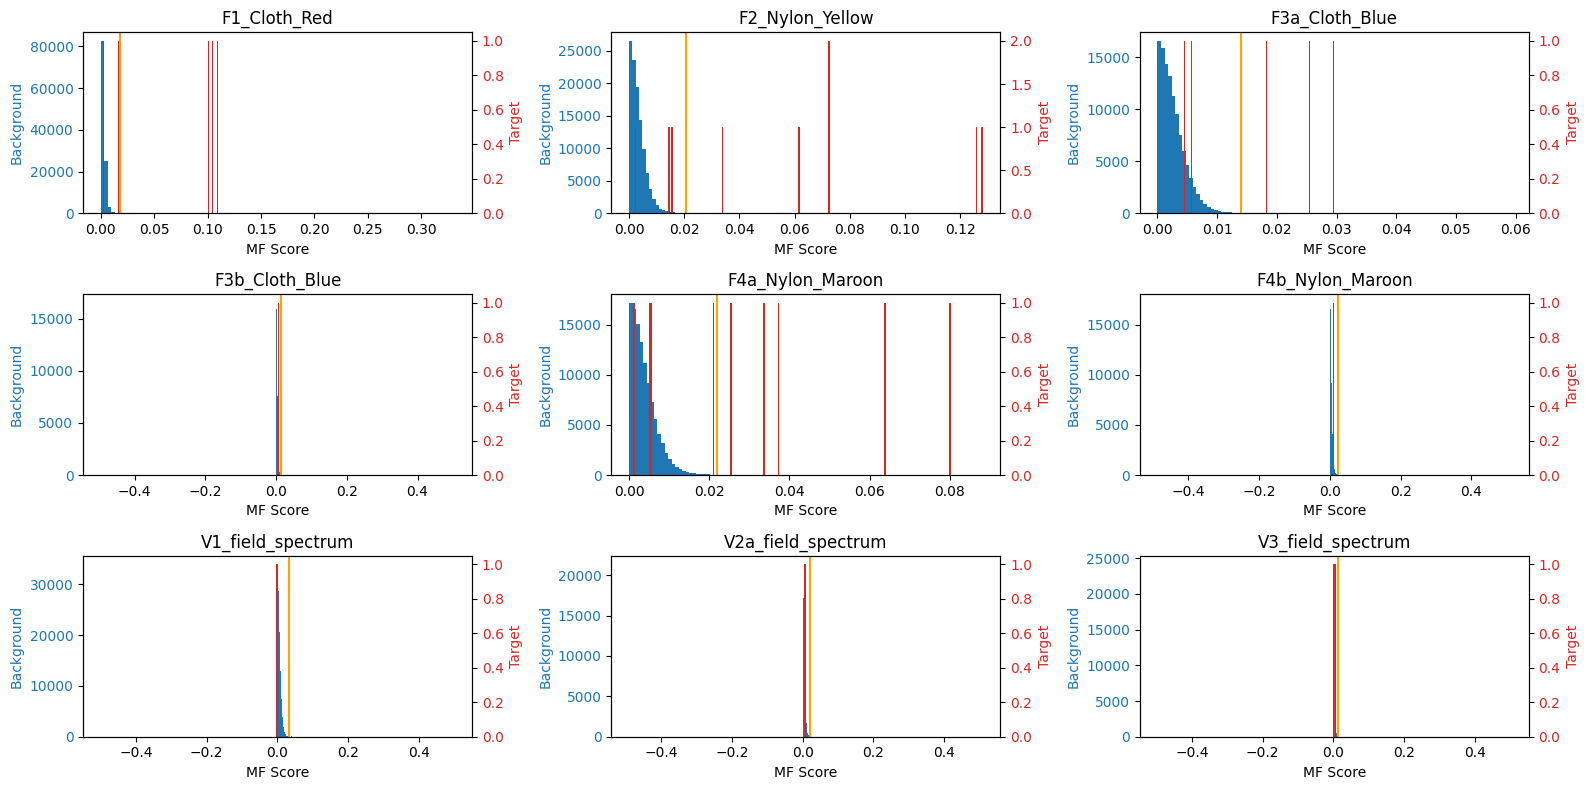

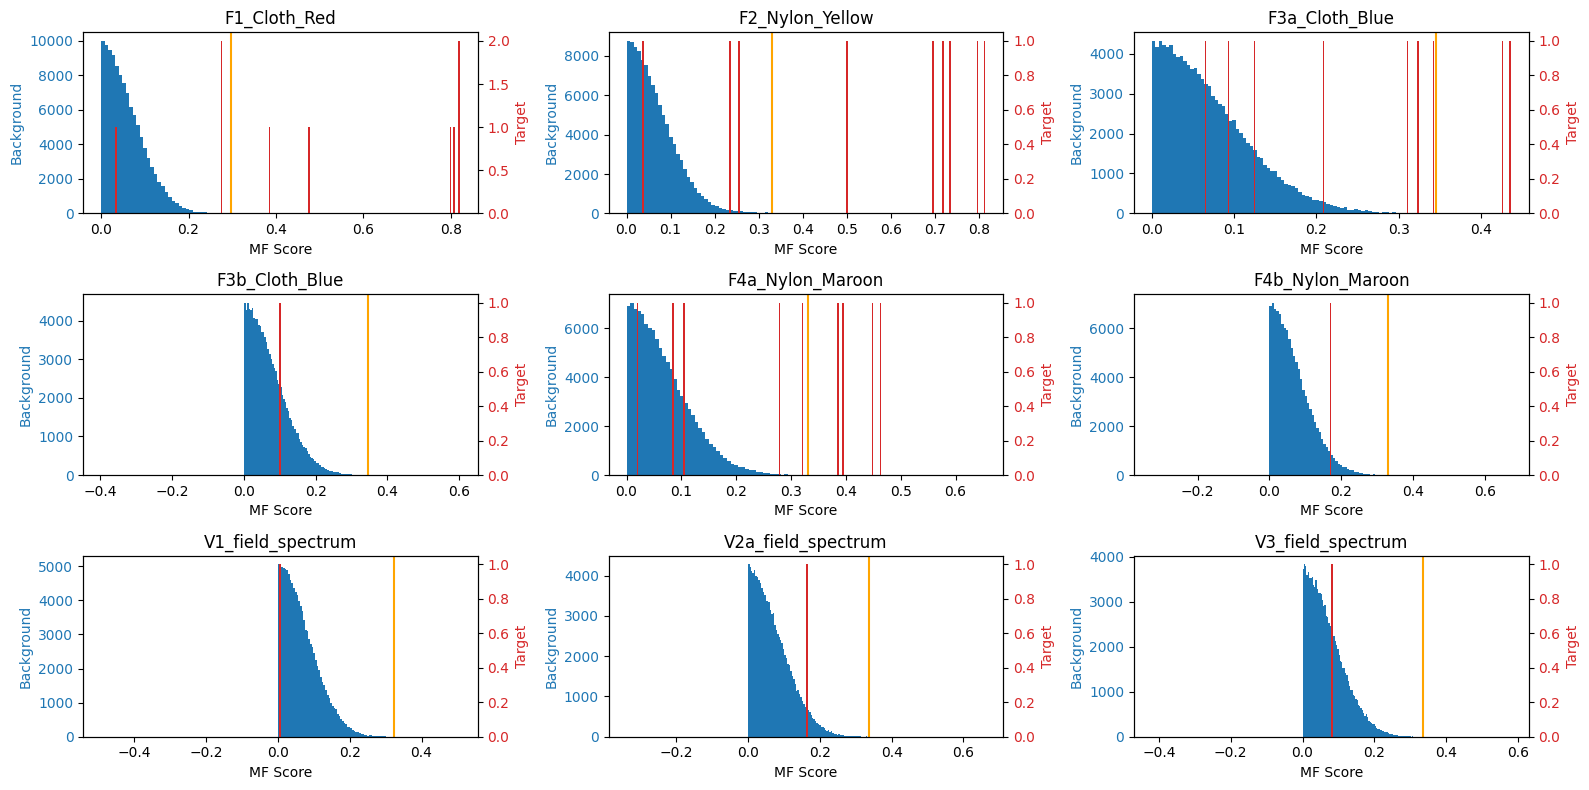

In [81]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = len(detector_class_idx)

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to index easily

    plot_idx = 0

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)


        # Histogram data
        if i in [0,1,2,4]:
            MD_within_class = MF_threshold.flatten()[np.where((gt_list == roi_idx[i]+1) | (gt_list == roi_full_idx[i]+1))] #add one to skip ground_truth class
        else:
            MD_within_class = MF_threshold.flatten()[np.where(gt_list == roi_idx[i]+1)[0]] #add one to skip ground_truth class
        MD_other_classes = MF_threshold.flatten()[np.where(gt_list != roi_idx[i]+1)[0]] #add one to skip ground_truth class


        ax1 = axes[plot_idx]  # Access the current subplot
        # Background histogram
        color = 'tab:blue'
        ax1.set_xlabel('MF Score')
        ax1.set_ylabel('Background', color=color)
        ax1.hist(MD_other_classes[MD_other_classes > 0], bins=100, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # Target histogram using secondary y-axis
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Target', color=color)
        ax2.hist(MD_within_class, bins = 200, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot threshold line
        ax1.axvline(m + 6 * s, color='orange')#, label=f'Threshold (6SD), {z}={(m + 6 * s):.3f}')

        # Title and legend
        ax1.set_title(f'{detector_class_name[i]}')
        #ax1.grid(True)
        #ax1.legend(loc='upper right')

        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


# False Alarm Rates

In [63]:
fa_rate = []
tp_rate = []

for z in formulas:

    mf_fa_rate = []
    mf_tp_rate = []

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:,:,detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:,:,detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold<0] = 0
        detections = np.where(MF_threshold>m+6*s)
        detections = [list(i) for i in zip(detections[0], detections[1])]

        # ROIS
        rois = groundtruth_classes[roi_sub_name[i]]['locations']
        rois = [[int(num) for num in sublist] for sublist in rois]

        #Guards
        guards = groundtruth_classes[roi_guard_name[i]]['locations']
        guards = [[int(num) for num in sublist] for sublist in guards]

        false_alarms = [item for item in detections if item not in rois and item not in guards]
        true_positives = [item for item in detections if item in rois]
        mf_fa_rate.append(len(false_alarms)/len(rois))
        mf_tp_rate.append(len(true_positives)/len(rois))

    ############ FALSE ALARM RATE TABLE ############
    fa_rate.append(mf_fa_rate)
    tp_rate.append(mf_tp_rate)

In [64]:
# False Alarm Rates
df = pd.DataFrame(fa_rate, columns=detector_class_name)
df.index = formulas
df

,F1_Cloth_Red,F2_Nylon_Yellow,F3a_Cloth_Blue,F3b_Cloth_Blue,F4a_Nylon_Maroon,F4b_Nylon_Maroon,V1_field_spectrum,V2a_field_spectrum,V3_field_spectrum
MF,30.375,87.00,31.00,255.0,59.500,481.0,414.0,388.0,430.0
ACE,24.625,27.75,1.25,14.0,6.125,52.0,38.0,15.0,11.0


In [65]:
# True Positive Rates
df1 = pd.DataFrame(tp_rate, columns=detector_class_name)
df1.index = formulas
df1

,F1_Cloth_Red,F2_Nylon_Yellow,F3a_Cloth_Blue,F3b_Cloth_Blue,F4a_Nylon_Maroon,F4b_Nylon_Maroon,V1_field_spectrum,V2a_field_spectrum,V3_field_spectrum
MF,0.625,0.625,0.375,0.0,0.500,0.0,0.0,0.0,0.0
ACE,0.625,0.625,0.250,0.0,0.375,0.0,0.0,0.0,0.0
